In [40]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

from IPython import display
import csv

# splitting test data and validation data
all_data = np.loadtxt("COMP90086_2023_TLLdataset/train.csv",
                 delimiter=",", dtype=str)

left_imgs = all_data[:,0][1:]
right_imgs = all_data[:,1][1:]

## path for training data and testing data
data_dir = "COMP90086_2023_TLLdataset/train"
data_dir_testing = "COMP90086_2023_TLLdataset/test"

##split data into 20% testing and 60% training and 20% validation
left_train, left_test, right_train, right_test = train_test_split(left_imgs, right_imgs, random_state=104, test_size = 0.2, shuffle=True)
left_train, left_val, right_train, right_val = train_test_split(left_train, right_train, random_state=104, test_size = 0.25, shuffle=True)

##testing data
all_testing_data = np.loadtxt("COMP90086_2023_TLLdataset/test_candidates.csv",
                 delimiter=",", dtype=str)
testing_data = all_testing_data[:,0][1:]
testing_candidates = all_testing_data[:,1:][1:]

print(testing_data.shape)
print(testing_candidates.shape)

(2000,)
(2000, 20)


In [41]:
##convert image names to gray scale image arrays:
def convert_left(array, data_dir):
    image_str = data_dir+"/left/"+array[0]+".jpg"
    img_array = cv2.imread(image_str, cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, (128, 128))
    total = np.array([img_array])
    
    for val in array[1:]:
        image_str = data_dir+"/left/"+val+".jpg"
        img_array = cv2.imread(image_str, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (128, 128))
        total = np.append(total, np.array([img_array]), axis = 0)
    return total

def convert_right(array, data_dir):
    image_str = data_dir+"/right/"+array[0]+".jpg"
    img_array = cv2.imread(image_str, cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, (128, 128))
    total = np.array([img_array])
    
    for val in array[1:]:
        image_str = data_dir+"/right/"+val+".jpg"
        img_array = cv2.imread(image_str, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (128, 128))
        total = np.append(total, np.array([img_array]), axis = 0)
    return total

In [42]:
left_train_img_arrays = convert_left(left_train, data_dir)
left_val_img_arrays = convert_left(left_val, data_dir)

right_train_img_arrays = convert_right(right_train, data_dir)
right_val_img_arrays = convert_right(right_val, data_dir)
print(left_val_img_arrays.shape)

(400, 128, 128)


In [43]:
# Normalize and reshape the data
left_train_img_arrays = left_train_img_arrays.astype('float32') / 255.
left_val_img_arrays = left_val_img_arrays.astype('float32') / 255.

right_train_img_arrays = right_train_img_arrays.astype('float32') / 255.
right_val_img_arrays = right_val_img_arrays.astype('float32') / 255.


x_left_train = np.reshape(left_train_img_arrays, (len(left_train_img_arrays), 128, 128, 1))
x_left_val = np.reshape(left_val_img_arrays, (len(left_val_img_arrays), 128, 128, 1))

x_right_train = np.reshape(right_train_img_arrays, (len(right_train_img_arrays), 128, 128, 1))
x_right_val = np.reshape(right_val_img_arrays, (len(right_val_img_arrays), 128, 128, 1))

# Testing:
'''left_testing_array = left_testing_array.astype('float32') / 255.
right_testing_array = right_testing_array.astype('float32') / 255.

x_left_test = np.reshape(left_testing_array, (len(left_testing_array), 128, 128, 1))
x_right_testing = np.reshape(right_testing_array, (len(right_testing_array), 128, 128, 1))'''

#For full connected layer
#x_left_train = left_train_img_arrays.reshape((len(left_train_img_arrays), np.prod(left_train_img_arrays.shape[1:])))
#x_left_val = left_val_img_arrays.reshape((len(left_val_img_arrays), np.prod(left_val_img_arrays.shape[1:])))

#x_right_train = right_train_img_arrays.reshape((len(right_train_img_arrays), np.prod(right_train_img_arrays.shape[1:])))
#x_right_val = right_val_img_arrays.reshape((len(right_val_img_arrays), np.prod(right_val_img_arrays.shape[1:])))

print("train_images shape:", x_left_train.shape)


train_images shape: (1200, 128, 128, 1)


In [27]:
from keras.layers import LeakyReLU
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', input_shape = (128, 128, 3) ,include_top = False)
base_model.trainable = False


input = layers.Input(shape=(128, 128, 3))
x = base_model(input, training = False)
x = layers.Conv2DTranspose(4, (3, 3), strides=2, kernel_initializer = 'he_uniform', padding="same")(x)
x = layers.Conv2DTranspose(4, (3, 3), strides=2, kernel_initializer = 'he_uniform', padding="same")(x)
x = layers.Conv2DTranspose(4, (3, 3), strides=2, kernel_initializer = 'he_uniform', padding="same")(x)
x = layers.Conv2DTranspose(4, (3, 3), strides=2, kernel_initializer = 'he_uniform', padding="same")(x)
x = layers.Conv2DTranspose(4, (3, 3), strides=2, kernel_initializer = 'he_uniform', padding="same")(x)
x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer = 'he_uniform')(x)
x = layers.LeakyReLU(alpha = 0.1)(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), kernel_initializer = 'he_uniform', padding='same')(x)
x = layers.LeakyReLU(alpha = 0.1)(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), kernel_initializer = 'he_uniform', padding='same')(x)
x = layers.LeakyReLU(alpha = 0.1)(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# transpose 
x = layers.Conv2DTranspose(32, (3, 3), strides=2, kernel_initializer = 'he_uniform', padding="same")(encoded)
x = layers.LeakyReLU(alpha = 0.1)(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, kernel_initializer = 'he_uniform', padding="same")(x)
x = layers.LeakyReLU(alpha = 0.1)(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

autoencoder.fit(x_left_train, x_right_train,
                epochs=15,
                batch_size=32,
                shuffle=True,
                validation_data=(x_left_val, x_right_val))

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 conv2d_transpose_51 (Conv2  (None, 8, 8, 4)           73732     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_52 (Conv2  (None, 16, 16, 4)         148       
 DTranspose)                                                     
                                                                 
 conv2d_transpose_53 (Conv2  (None, 32, 32, 4)         148       
 DTranspose)                                                     
                                                           

KeyboardInterrupt: 

In [52]:
#Convolutional autoencoder
from keras.layers import LeakyReLU
from keras.applications import ResNet50


input = layers.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer = 'he_uniform')(input)
x = layers.LeakyReLU(alpha = 0.1)(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), kernel_initializer = 'he_uniform', padding='same')(x)
x = layers.LeakyReLU(alpha = 0.1)(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), kernel_initializer = 'he_uniform', padding='same')(x)
x = layers.LeakyReLU(alpha = 0.1)(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# transpose 
x = layers.Conv2DTranspose(32, (3, 3), strides=2, kernel_initializer = 'he_uniform', padding="same")(encoded)
x = layers.LeakyReLU(alpha = 0.1)(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, kernel_initializer = 'he_uniform', padding="same")(x)
x = layers.LeakyReLU(alpha = 0.1)(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

autoencoder.summary()

'''all_data_train = np.append(x_right_train, x_left_train, axis = 0)
print(all_data_train.shape)
print(x_right_train.shape)
print(x_left_train.shape)
all_data_val = np.append(x_right_val, x_left_val, axis = 0)
print(all_data_val.shape)
print(x_right_train.shape)
print(x_left_train.shape)'''

history = autoencoder.fit(x_left_train, x_right_train,
                epochs=15,
                batch_size=3,
                shuffle=True,
                validation_data=(x_left_val, x_right_val))


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_61 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 leaky_re_lu_75 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 leaky_re_lu_76 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                          

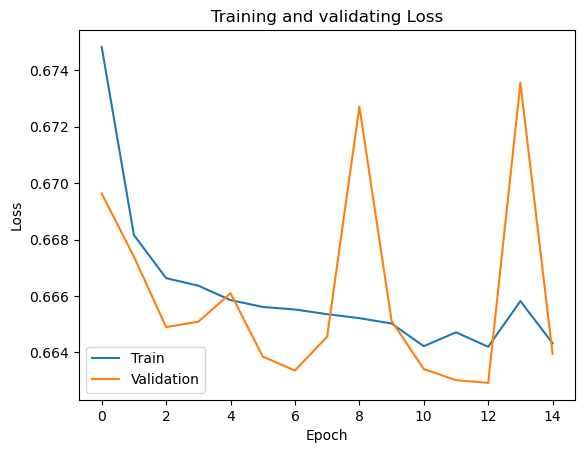

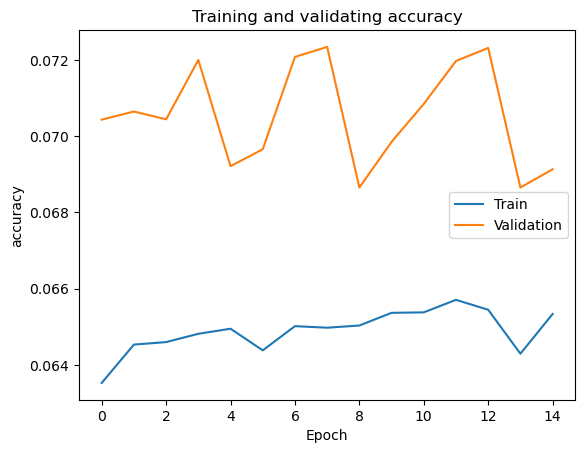

In [55]:
import matplotlib.pyplot as plt
print(autoencoder.history)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and validating Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.title('Training and validating accuracy')
plt.legend()
plt.show()

In [45]:
## extracting the encoder
encoder = keras.Model(input, encoded)




In [38]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def preprocess_image(image_path, target_size):
    #image = load_img(image_path, target_size=target_size)
    #image = img_to_array(image)
    #image = image / 255.0  # Normalize pixel values
    img_array = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_array = cv2.resize(img_array, (128, 128))
    img_array = img_array / 255.0
    return img_array
def compute_similarity(image1_path, image2_path, encoder):
    # Preprocess the input images
    input_shape = (128, 128, 3)
    image1 = preprocess_image(image1_path, input_shape[:2])
    image2 = preprocess_image(image2_path, input_shape[:2])

    # Encode the images using the trained Siamese network
    encoded_image1 = encoder.predict(np.expand_dims(image1, axis=0), verbose=0)
    encoded_image2 = encoder.predict(np.expand_dims(image2, axis=0), verbose=0)

    # Compute the similarity score using cosine similarity
    encoded_image1 = encoded_image1.reshape(1,-1)
    encoded_image2 = encoded_image2.reshape(1,-1)
    similarity_score = cosine_similarity(encoded_image1, encoded_image2)[0][0]

    return similarity_score

input_shape = (128, 128, 3)

# Load test_candidates.csv
test_candidates_csv = "COMP90086_2023_TLLdataset/test_candidates.csv"  # Replace with the correct file path
test_candidates_data = pd.read_csv(test_candidates_csv)

# Create a list to store the results
results = []
processed_count = 0
# Loop through each row in test_candidates.csv
for index, row in test_candidates_data.iterrows():
    left_image_path = "COMP90086_2023_TLLdataset/test/left/" + row["left"] + ".jpg"
    similarity_scores = []
    
    # Loop through columns "c0" to "c19" and compute similarity scores
    for i in range(20):
        right_image_path = "COMP90086_2023_TLLdataset/test/right/" + row["c" + str(i)] + ".jpg"
        similarity_score = compute_similarity(left_image_path, right_image_path, encoder)
        similarity_scores.append(similarity_score)
    
    results.append(similarity_scores)
    # Increment the count of processed "left" images
    processed_count += 1
    print(f"Processed {processed_count} left images.")

# Create a DataFrame for the results
results_df = pd.DataFrame(results, columns=["c" + str(i) for i in range(20)])

# Combine "left" column from the original test_candidates.csv with the results
results_df.insert(0, "left", test_candidates_data["left"])

# Save the results to a new CSV file
results_csv = "results2.csv"  
results_df.to_csv(results_csv, index=False)

Processed 1 left images.
Processed 2 left images.
Processed 3 left images.
Processed 4 left images.
Processed 5 left images.
Processed 6 left images.
Processed 7 left images.
Processed 8 left images.
Processed 9 left images.
Processed 10 left images.
Processed 11 left images.
Processed 12 left images.
Processed 13 left images.
Processed 14 left images.
Processed 15 left images.
Processed 16 left images.


KeyboardInterrupt: 

In [55]:
## cleaning up the csv
res = pd.read_csv('results2.csv')
def clean(x):
    val = x[2:]
    res = val[:-2]
    res = float(res)
    return res

rand = 'c'
for i in range(20): 
    idx = rand + str(i)
    res[idx] = res[idx].apply(clean)
print(res)

res.to_csv("res2.csv", index = False)

     left        c0        c1        c2        c3        c4        c5  \
0     abm  0.751466  0.874093  0.929270  0.657284  0.619256  0.718198   
1     aci  0.870800  0.868596  0.848672  0.796843  0.908110  0.864201   
2     acn  0.866436  0.899032  0.800879  0.812065  0.851788  0.774639   
3     aco  0.698820  0.837216  0.828223  0.835885  0.854704  0.890554   
4     acu  0.855306  0.920505  0.878199  0.762013  0.853588  0.851321   
...   ...       ...       ...       ...       ...       ...       ...   
1995  zyc  0.946665  0.817088  0.731548  0.745439  0.688317  0.847711   
1996  zyi  0.826676  0.811831  0.756318  0.764954  0.562093  0.696498   
1997  zym  0.798482  0.812668  0.873420  0.876307  0.841356  0.815361   
1998  zzq  0.924577  0.902200  0.872832  0.853565  0.893430  0.796082   
1999  zzr  0.628045  0.872963  0.862319  0.787420  0.840988  0.809157   

            c6        c7        c8  ...       c10       c11       c12  \
0     0.410612  0.792814  0.825921  ...  0.689725 

In [39]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# preprocess the left and right testing images
left_testing_imgs = convert_left(left_test, data_dir)
left_testing_imgs = left_testing_imgs.astype('float32') / 255.
## fully connected layer preprocessing:
## x_left = left_img.reshape((len(left_img), np.prod(left_img.shape[1:])))
x_left_testing_imgs = np.reshape(left_testing_imgs, (len(left_testing_imgs), 128, 128, 1))

encoded_features_left = encoder.predict(x_left_testing_imgs)

right_testing_imgs = convert_right(right_test, data_dir)
right_testing_imgs = right_testing_imgs.astype('float32') / 255.
## fully connected layer preprocessing:
## x_right = right_img.reshape((len(right_img), np.prod(right_img.shape[1:])))
x_right_testing_imgs = np.reshape(right_testing_imgs, (len(right_testing_imgs), 128, 128, 1))
encoded_features_right= encoder.predict(x_right_testing_imgs)

# creating a list of (image name, features of the image) for right images for shuffling later
res = [(right_test[i], encoded_features_right[i]) for i in range(len(right_test))]

##print(encoded_features_left.shape)

NameError: name 'left_test' is not defined

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import random
count = 0
total_matches = 0
for left_img_features in (encoded_features_left):
    # randomly sample n images from the right side to compare to the left image
    n = 19
    matched = False
    random_19 = random.sample(res, n)
    labels = [label for (label, _) in random_19]
    random_19_features = np.array([feature for (_, feature) in random_19])
    labels = [res[count][0]] + labels
    
    right_features_images = np.append([encoded_features_right[count]], random_19_features, axis = 0)
    #similarity list for all the random 20 right_features with the given left_feature
    array_similarities = []
    
    
    for feature in right_features_images:
        feature = feature.reshape(1,-1)
        org_img_feature = left_img_features.reshape(1,-1)
        sim = cosine_similarity(org_img_feature, feature)
        array_similarities.append(sim)

    #sort the similarities and plot the top 2 images with the best similarities
    array_similarities = [(label, sim) for label, sim in zip(labels, array_similarities)]
    array_similarities.sort(key=lambda x: x[1], reverse=True)
    
    n_similar = 3  # Number of similar images to display
    for j in range(n_similar):
        image_name = array_similarities[j][0]
        if(image_name == right_test[count]):
            matched = True
    if (matched):
        total_matches += 1
    '''plt.figure(figsize=(10, 10))
    for j in range(n_similar):
        ax = plt.subplot(2, n_similar, j + 1)
        image_name = array_similarities[j][0]
        if (image_name == right_test[count]):
            matched = True
        image = convert_right([image_name], data_dir)[0]
        plt.imshow(image, cmap = 'gray')
        plt.title("image "+image_name)
    if (matched):
        total_matches += 1
    plt.show()
    plt.figure()
    plt.imshow(left_testing_imgs[count], cmap = 'gray')
    plt.title(left_test[count])
    plt.show()
    plt.figure()
    plt.imshow(right_testing_imgs[count], cmap = 'gray')
    plt.title(right_test[count])
    plt.show()
    count += 1'''
    count += 1
#Evaluate the model:


In [12]:
print(total_matches)
print(total_matches/400)

141
0.3525
